# Multi-class Classification: Sign Language

This project uses the [Sign Language MNIST](https://www.kaggle.com/datamunge/sign-language-mnist) dataset, which contains 28x28 images of hands depicting the 26 letters of the English alphabet.



In [18]:
import csv
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

Download the training and test sets.

In [19]:
# sign_mnist_train.csv
!gdown 1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
# sign_mnist_test.csv
!gdown 1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg

Downloading...
From: https://drive.google.com/uc?id=1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
To: /content/sign_mnist_train.csv
100% 83.3M/83.3M [00:00<00:00, 167MB/s]
Downloading...
From: https://drive.google.com/uc?id=1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg
To: /content/sign_mnist_test.csv
100% 21.8M/21.8M [00:00<00:00, 153MB/s] 


In [20]:
TRAINING_FILE = './sign_mnist_train.csv'
VALIDATION_FILE = './sign_mnist_test.csv'

In [21]:
with open(TRAINING_FILE) as training_file:
  df = pd.read_csv('sign_mnist_test.csv')
  print('Columns: \n', df.columns)
  print('')
  print('First 3 rows: \n', df.head(3))


Columns: 
 Index(['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=785)

First 3 rows: 
    label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      6     149     149     150     150     150     151     151     150   
1      5     126     128     131     132     133     134     135     135   
2     10      85      88      92      96     105     123     135     143   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0     151  ...       138       148       127        89        82        96   
1     136  ...        47       104       194       183       186       184   
2     147  ...        68       166       242       227       230       227   

   pixel781  pixel782  pixel783  pixel784  
0       106      

Each file includes a header and each subsequent data point is represented as a line that contains 785 values.

The first value is the label (the numeric representation of each letter) and the other 784 values are the value of each pixel of the image. The original images have a resolution of 28x28, which sums up to 784 pixels.

 ## Parsing the dataset

 This function reads a file passed as input and returns 2 numpy arrays, one containing the labels and one containing the 28x28 representation of each image within the file.
  

In [22]:
def parse_data_from_input(filename):
  """
  Parses the images and labels from a CSV file

  Args:
    filename (string): path to the CSV file

  Returns:
    images, labels: tuple of numpy arrays containing the images and labels
  """
  with open(filename) as file:
    csv_reader = csv.reader(file, delimiter=',')
    next(csv_reader)
    labels = []
    images = []

    for row in csv_reader:
      labels.append(row[0])
      pixels = np.array(row[1:])
      pixels = np.array_split(pixels, 28)
      images.append(pixels)

    labels = np.array(labels)
    images = np.array(images)

    labels = labels.astype(float)
    images = images.astype(float)

    return images, labels

In [23]:
training_images, training_labels = parse_data_from_input(TRAINING_FILE)
validation_images, validation_labels = parse_data_from_input(VALIDATION_FILE)

print(f"Training images has shape: {training_images.shape} and dtype: {training_images.dtype}")
print(f"Training labels has shape: {training_labels.shape} and dtype: {training_labels.dtype}")
print(f"Validation images has shape: {validation_images.shape} and dtype: {validation_images.dtype}")
print(f"Validation labels has shape: {validation_labels.shape} and dtype: {validation_labels.dtype}")

Training images has shape: (27455, 28, 28) and dtype: float64
Training labels has shape: (27455,) and dtype: float64
Validation images has shape: (7172, 28, 28) and dtype: float64
Validation labels has shape: (7172,) and dtype: float64


## Visualizing the numpy arrays

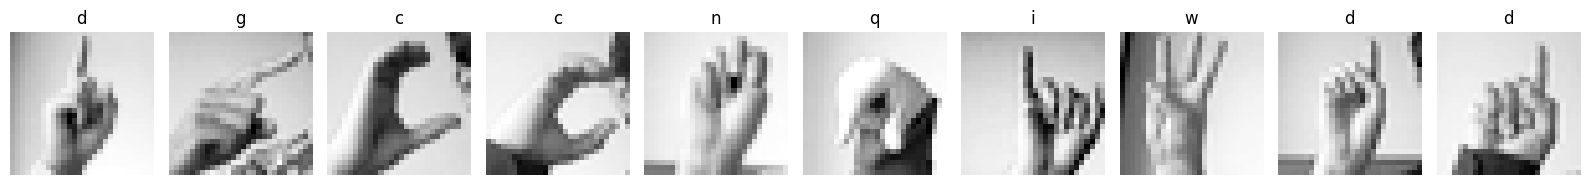

In [24]:
# Plots a sample of 10 images from the training set
def plot_categories(training_images, training_labels):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for k in range(10):
    img = training_images[k]
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{letters[int(training_labels[k])]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(training_images, training_labels)

## Creating the generators for the CNN


In [25]:
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
  """
  Creates the training and validation data generators

  Args:
    training_images (array): parsed images from the train CSV file
    training_labels (array): parsed labels from the train CSV file
    validation_images (array): parsed images from the test CSV file
    validation_labels (array): parsed labels from the test CSV file

  Returns:
    train_generator, validation_generator - tuple containing the generators
  """

  training_images = np.expand_dims(training_images, axis=3)
  validation_images = np.expand_dims(validation_images, axis=3)

  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.2,
                                     height_shift_range=0.2,
                                     width_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=False,
                                     fill_mode='nearest'
                                     )

  train_generator = train_datagen.flow(x=training_images,
                                       y=training_labels,
                                       batch_size=32)

  validation_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.1,
                                     height_shift_range=0.2,
                                     width_shift_range=0.2,
                                     shear_range=0.1,
                                     zoom_range=0.2,
                                     horizontal_flip=False,
                                     fill_mode='nearest'
                                     )

  validation_generator = validation_datagen.flow(x=validation_images,
                                                 y=validation_labels,
                                                 batch_size=32)


  return train_generator, validation_generator

In [26]:
train_generator, validation_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (27455, 28, 28, 1)
Labels of training generator have shape: (27455,)
Images of validation generator have shape: (7172, 28, 28, 1)
Labels of validation generator have shape: (7172,)


## Coding the CNN

In [27]:
# grader-required-cell

def create_model():
  model = tf.keras.models.Sequential([
                              # 1st Convolution
                              tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
                              tf.keras.layers.MaxPooling2D((2,2)),
                              # 2nd Convolution
                              tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                              tf.keras.layers.MaxPooling2D((2,2)),

                              tf.keras.layers.Flatten(),
                              tf.keras.layers.Dropout(0.3),
                              tf.keras.layers.Dense(128, activation='relu'),
                              tf.keras.layers.Dense(25, activation='softmax')
  ])

  model.compile(optimizer = 'adam',
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [28]:
model = create_model()

# Train
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator)

Epoch 1/15
858/858 [==============================] - 39s 32ms/step - loss: 2.3614 - accuracy: 0.2844 - val_loss: 1.6153 - val_accuracy: 0.4615
Epoch 2/15
858/858 [==============================] - 26s 31ms/step - loss: 1.2934 - accuracy: 0.5831 - val_loss: 1.1111 - val_accuracy: 0.6492
Epoch 3/15
858/858 [==============================] - 26s 30ms/step - loss: 0.9469 - accuracy: 0.6904 - val_loss: 0.8255 - val_accuracy: 0.7144
Epoch 4/15
858/858 [==============================] - 26s 31ms/step - loss: 0.7434 - accuracy: 0.7522 - val_loss: 0.6172 - val_accuracy: 0.7971
Epoch 5/15
858/858 [==============================] - 21s 24ms/step - loss: 0.6192 - accuracy: 0.7961 - val_loss: 0.5330 - val_accuracy: 0.8261
Epoch 6/15
858/858 [==============================] - 20s 24ms/step - loss: 0.5362 - accuracy: 0.8212 - val_loss: 0.4604 - val_accuracy: 0.8544
Epoch 7/15
858/858 [==============================] - 26s 30ms/step - loss: 0.4740 - accuracy: 0.8410 - val_loss: 0.4147 - val_accuracy:

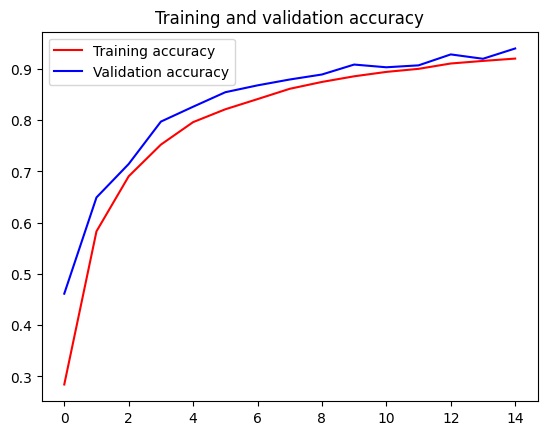

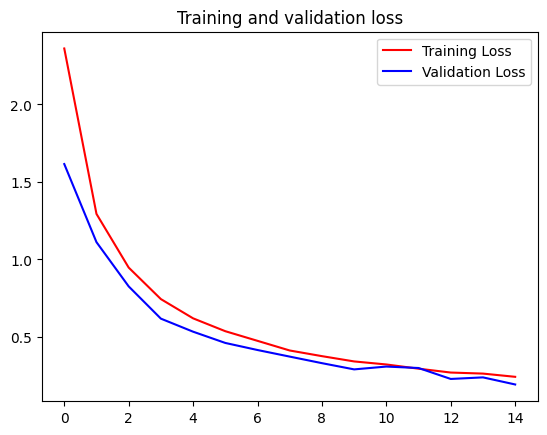

In [29]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# How does dropout affect Accuracy?

I had a dropout of 0.3 in the model. Lets see what happens when we increase or decrease it.

In [31]:

def create_model(dropout):
  model = tf.keras.models.Sequential([
                              # 1st Convolution
                              tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
                              tf.keras.layers.MaxPooling2D((2,2)),
                              # 2nd Convolution
                              tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                              tf.keras.layers.MaxPooling2D((2,2)),

                              tf.keras.layers.Flatten(),
                              tf.keras.layers.Dropout(dropout),
                              tf.keras.layers.Dense(128, activation='relu'),
                              tf.keras.layers.Dense(25, activation='softmax')
  ])

  model.compile(optimizer = 'adam',
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model




I'm going to bring it down to 10 epochs to reduce training time.

In [34]:
dropoutDict = {}

# Test dropout from 0 to .60 in 20% increments
for i in range(0, 7, 2):
  dropout_rate = i / 10

  print(f'Currently testing dropout_rate of {dropout_rate}')
  model = create_model(dropout_rate)

  # Train
  history = model.fit(train_generator,
                      epochs=10,
                      validation_data=validation_generator)
  dropoutDict[dropout_rate] = history

Currently testing dropout_rate of 0.0
Epoch 1/10
858/858 [==============================] - 19s 20ms/step - loss: 2.2143 - accuracy: 0.3315 - val_loss: 1.5229 - val_accuracy: 0.5146
Epoch 2/10
858/858 [==============================] - 23s 27ms/step - loss: 1.1179 - accuracy: 0.6402 - val_loss: 1.0223 - val_accuracy: 0.6645
Epoch 3/10
858/858 [==============================] - 28s 32ms/step - loss: 0.7726 - accuracy: 0.7509 - val_loss: 0.8107 - val_accuracy: 0.7333
Epoch 4/10
858/858 [==============================] - 20s 23ms/step - loss: 0.5968 - accuracy: 0.8055 - val_loss: 0.7167 - val_accuracy: 0.7552
Epoch 5/10
858/858 [==============================] - 19s 22ms/step - loss: 0.4881 - accuracy: 0.8433 - val_loss: 0.5348 - val_accuracy: 0.8217
Epoch 6/10
858/858 [==============================] - 25s 29ms/step - loss: 0.4075 - accuracy: 0.8665 - val_loss: 0.5213 - val_accuracy: 0.8286
Epoch 7/10
858/858 [==============================] - 19s 22ms/step - loss: 0.3477 - accuracy: 0.8

In [80]:
def summarize():
  models = [0.0, 0.2, 0.4, 0.6]

  for model in dropoutDict:


    history = dropoutDict[model]

    trainAcc = history.history['accuracy']
    valAcc = history.history['val_accuracy']
    trainLoss = history.history['loss']
    valLoss = history.history['val_loss']

    print(f'Highest Scores for Dropout of {model}')
    print('Training Accuracy: ', max(trainAcc))
    print('Validation Accuracy: ', max(valAcc))
    print('Training Loss: ', max(trainLoss))
    print('Validation Loss: ', max(valLoss))
    print('')


In [81]:
summarize()

Highest Scores for Dropout of 0.0
Training Accuracy:  0.9266800284385681
Validation Accuracy:  0.8802286386489868
Training Loss:  2.214252471923828
Validation Loss:  1.5228773355484009

Highest Scores for Dropout of 0.2
Training Accuracy:  0.8813331127166748
Validation Accuracy:  0.8920803070068359
Training Loss:  2.467088460922241
Validation Loss:  1.7243989706039429

Highest Scores for Dropout of 0.4
Training Accuracy:  0.9002732038497925
Validation Accuracy:  0.9184327721595764
Training Loss:  2.2597458362579346
Validation Loss:  1.5865260362625122

Highest Scores for Dropout of 0.6
Training Accuracy:  0.8441813588142395
Validation Accuracy:  0.8908254504203796
Training Loss:  2.4759039878845215
Validation Loss:  1.7030917406082153



In [ ]:
def plot_accuracy():
# Plot the chart for accuracy on both training and validation


  for model in dropoutDict:
    history = dropoutDict[model]

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy with Dropout of ' + str(model))
    plt.legend()
    plt.figure()

  plt.show()


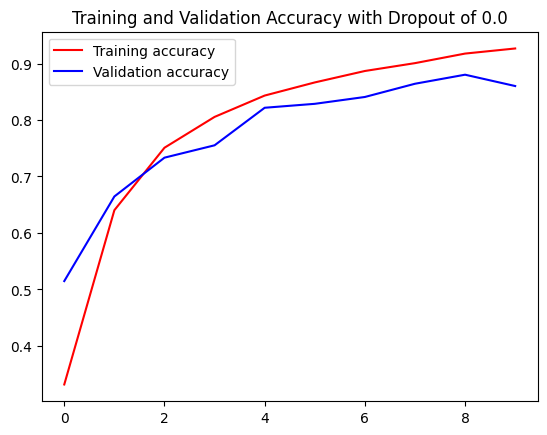

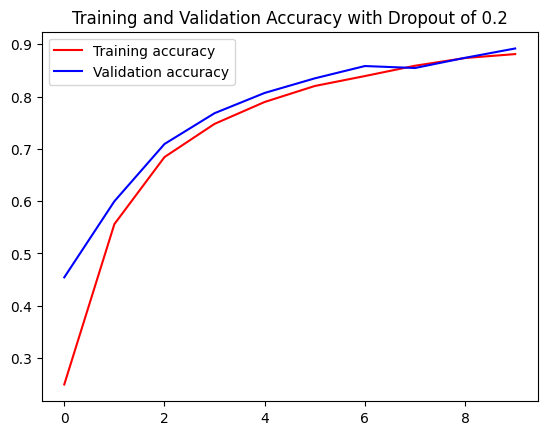

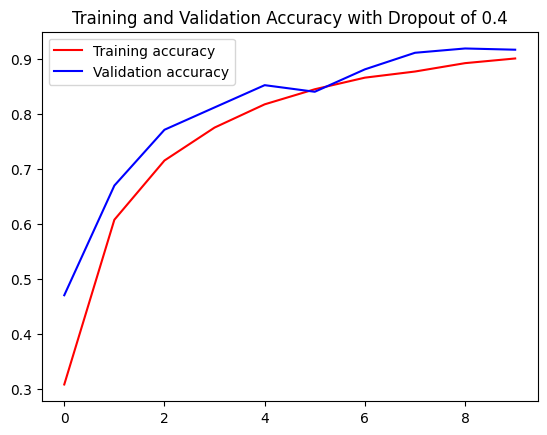

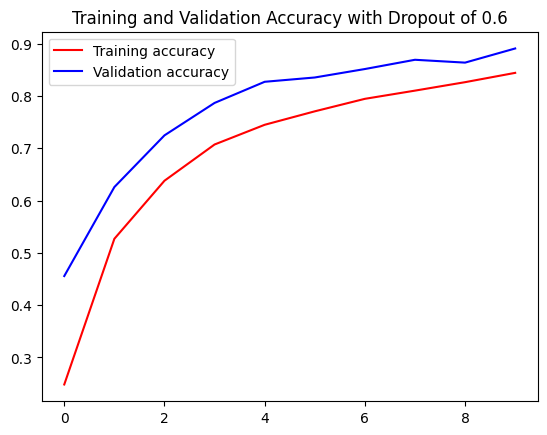

<Figure size 640x480 with 0 Axes>

In [38]:
plot_accuracy()

In [ ]:
def plot_loss():
# Plot the chart for loss on both training and validation


  for model in dropoutDict:
    history = dropoutDict[model]

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss with Dropout of ' + str(model))
    plt.legend()
    plt.figure()

  plt.show()

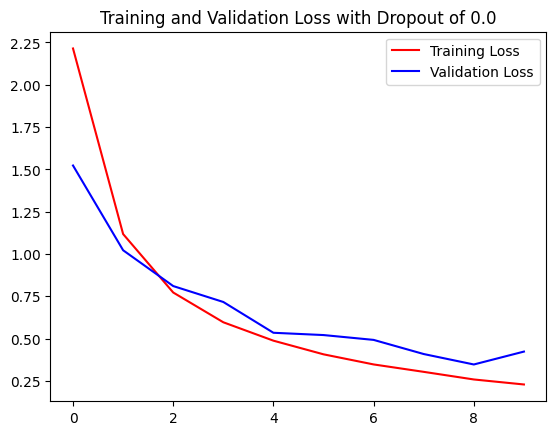

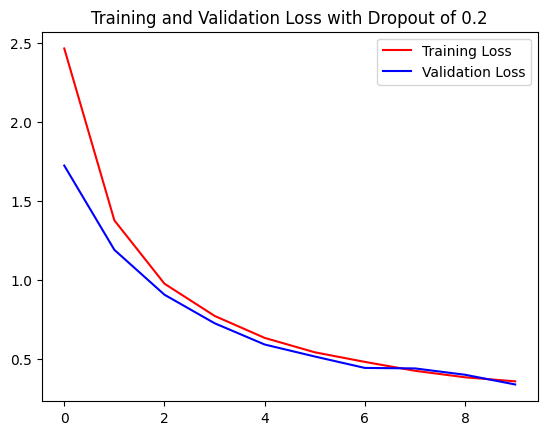

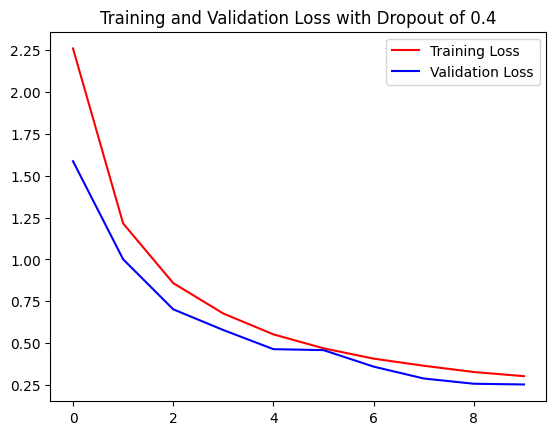

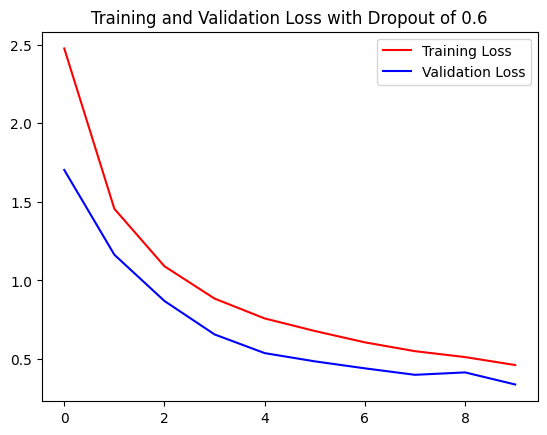

<Figure size 640x480 with 0 Axes>

In [39]:
plot_loss()